# 1er Entregable: Data Preparation
### Deadline: 24/05/2024

### Importamos librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, OrdinalEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importamos el dataset

In [4]:
bmw=pd.read_csv("/content/drive/MyDrive/NUCLIO/bmw_pricing_v3.csv")

### Algunos comandos simples para Data Discovery

In [5]:
bmw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        3873 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               2420 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4398 non-null   object 
 7   tipo_coche                   3383 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4357 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  1452 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

In [6]:
bmw.head(5)

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,NaN,118,140411.0,100.0,2012-02-01,diesel,black,NaN,True,True,False,NaN,True,NaN,True,NaN,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,NaN,petrol,grey,convertible,True,True,False,NaN,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,NaN,False,False,False,NaN,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,NaN,diesel,red,convertible,True,True,False,NaN,True,True,True,NaN,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,NaN,diesel,silver,NaN,True,True,False,False,False,True,True,True,33400.0,2018-04-01


In [7]:
bmw.describe()

,km,potencia,precio
count,4.841000e+03,4842.000000,4837.000000
mean,1.409593e+05,128.981826,15831.920612
std,6.020853e+04,38.994839,9222.630708
min,-6.400000e+01,0.000000,100.000000
25%,1.028840e+05,100.000000,10800.000000
50%,1.410800e+05,120.000000,14200.000000
75%,1.752170e+05,135.000000,18600.000000
max,1.000376e+06,423.000000,178500.000000


#### Como análisis previo, vemos que hay que limpiar float negativo en km, potencia 0, eliminar algunas columnas que no son relevantes para predecir precio: marca (ya sabemos que es BMW), limpiar el Diesel a diesel, trato de nulos, etc. No hay dups.

In [8]:
bmw.isnull().sum()

marca                           970
modelo                            3
km                                2
potencia                          1
fecha_registro                 2423
tipo_gasolina                     5
color                           445
tipo_coche                     1460
volante_regulable                 4
aire_acondicionado              486
camara_trasera                    2
asientos_traseros_plegables    3391
elevalunas_electrico              2
bluetooth                       728
gps                               0
alerta_lim_velocidad            728
precio                            6
fecha_venta                       1
dtype: int64

In [9]:
bmw[bmw.duplicated(keep=False)]

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta


In [10]:
for i in bmw:
    print('\n', i, bmw[i].value_counts(normalize=True),'\n')


 marca marca
BMW    1.0
Name: proportion, dtype: float64 


 modelo modelo
320                0.155372
520                0.130785
318                0.117355
X3                 0.090496
116                0.073967
                     ...   
M135               0.000207
225                0.000207
i8                 0.000207
630                0.000207
214 Gran Tourer    0.000207
Name: proportion, Length: 76, dtype: float64 


 km km
123492.0    0.000413
120833.0    0.000413
180232.0    0.000413
124822.0    0.000413
116708.0    0.000413
              ...   
133178.0    0.000207
105959.0    0.000207
193231.0    0.000207
84058.0     0.000207
195840.0    0.000207
Name: proportion, Length: 4784, dtype: float64 


 potencia potencia
135.0    0.182156
120.0    0.162123
85.0     0.130318
100.0    0.117720
105.0    0.093143
           ...   
224.0    0.000207
121.0    0.000207
239.0    0.000207
236.0    0.000207
261.0    0.000207
Name: proportion, Length: 61, dtype: float64 


 fecha_registro

In [11]:
bmw.shape[0]

4843

In [12]:
bmw2 = bmw.copy()

### Analizando los valores anteriores, hemos determinado unos umbrales para poder eliminar algunas columnas que no son relevantes para determinar la variable 'Precio'

In [13]:
columnas_null=[]

umbral_null = 70

for i in bmw2:
    pctnull=(bmw2[i].isnull().sum()/bmw2.shape[0])*100
    if pctnull>70:
        columnas_null.append(i)


print(f"Columnas a eliminar por alto volumen de valores nulos (mayor a {umbral_null}%)",columnas_null)


Columnas a eliminar por alto volumen de valores nulos (mayor a 70%) ['asientos_traseros_plegables']


In [14]:
columnas_irrelevantes = []

umbral_irr=90

for i in bmw2:
    pctirr = ((bmw2[i].value_counts(normalize=True))*100).iloc[0]
    if pctirr>umbral_irr:
        columnas_irrelevantes.append(i)


print(f"Columnas a eliminar por no ser repetitivas (mayor a {umbral_irr}%)", columnas_irrelevantes)

Columnas a eliminar por no ser repetitivas (mayor a 90%) ['marca', 'tipo_gasolina', 'gps']


In [15]:
columnas_eliminar=columnas_irrelevantes+columnas_null
print(columnas_eliminar)

['marca', 'tipo_gasolina', 'gps', 'asientos_traseros_plegables']


In [16]:
for i in columnas_eliminar:
    del bmw2[i]

In [17]:
bmw2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   modelo                4840 non-null   object 
 1   km                    4841 non-null   float64
 2   potencia              4842 non-null   float64
 3   fecha_registro        2420 non-null   object 
 4   color                 4398 non-null   object 
 5   tipo_coche            3383 non-null   object 
 6   volante_regulable     4839 non-null   object 
 7   aire_acondicionado    4357 non-null   object 
 8   camara_trasera        4841 non-null   object 
 9   elevalunas_electrico  4841 non-null   object 
 10  bluetooth             4115 non-null   object 
 11  alerta_lim_velocidad  4115 non-null   object 
 12  precio                4837 non-null   float64
 13  fecha_venta           4842 non-null   object 
dtypes: float64(3), object(11)
memory usage: 529.8+ KB


#### Ahora vemos los nulos

In [18]:
bmw2.isnull().sum()

modelo                     3
km                         2
potencia                   1
fecha_registro          2423
color                    445
tipo_coche              1460
volante_regulable          4
aire_acondicionado       486
camara_trasera             2
elevalunas_electrico       2
bluetooth                728
alerta_lim_velocidad     728
precio                     6
fecha_venta                1
dtype: int64

### Tratamiento de nulos

In [19]:
bmw3=bmw2.copy()

In [20]:
for indice, linea in bmw3.iterrows():
    modelo = linea['modelo']
    bmw_test = bmw3[(bmw3['modelo'] == modelo) & (bmw3['tipo_coche'].notnull())].head(1)

    if not bmw_test.empty:
        tipo_coche = bmw_test['tipo_coche'].iloc[0]
        bmw3.loc[indice, 'tipo_coche'] = tipo_coche

In [21]:
pocos_nulos = []

umbral_pocos_nulos=7

for i in bmw3:
    vol_nul = bmw3[i].isnull().sum()
    #print(i,vol_nul)
    if (vol_nul<umbral_pocos_nulos):
        pocos_nulos.append(i)


print(f"Columnas a eliminar con pocos nulos (menor o igual a {umbral_pocos_nulos})", pocos_nulos)

Columnas a eliminar con pocos nulos (menor o igual a 7) ['modelo', 'km', 'potencia', 'tipo_coche', 'volante_regulable', 'camara_trasera', 'elevalunas_electrico', 'precio', 'fecha_venta']


In [22]:
bmw3.dropna(subset=pocos_nulos,inplace=True)

In [23]:
bmw3.reset_index(drop=True,inplace=True)

In [24]:
bmw3.isnull().sum()

modelo                     0
km                         0
potencia                   0
fecha_registro          2411
color                    442
tipo_coche                 0
volante_regulable          0
aire_acondicionado       483
camara_trasera             0
elevalunas_electrico       0
bluetooth                725
alerta_lim_velocidad     725
precio                     0
fecha_venta                0
dtype: int64

In [25]:
bmw4=bmw3.copy()

In [26]:
bmw4["fecha_registro"]=pd.to_datetime(bmw4["fecha_registro"])

In [27]:
bmw4["fecha_venta"]=pd.to_datetime(bmw4["fecha_venta"])

In [28]:
bmw4["antiguedad_days"]= bmw4['fecha_venta']-bmw4['fecha_registro']

In [29]:
bmw4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4822 entries, 0 to 4821
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   modelo                4822 non-null   object         
 1   km                    4822 non-null   float64        
 2   potencia              4822 non-null   float64        
 3   fecha_registro        2411 non-null   datetime64[ns] 
 4   color                 4380 non-null   object         
 5   tipo_coche            4822 non-null   object         
 6   volante_regulable     4822 non-null   object         
 7   aire_acondicionado    4339 non-null   object         
 8   camara_trasera        4822 non-null   object         
 9   elevalunas_electrico  4822 non-null   object         
 10  bluetooth             4097 non-null   object         
 11  alerta_lim_velocidad  4097 non-null   object         
 12  precio                4822 non-null   float64        
 13  fec

In [30]:
bmw4.head(5)

,modelo,km,potencia,fecha_registro,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,fecha_venta,antiguedad_days
0,118,140411.0,100.0,2012-02-01,black,convertible,True,True,False,True,NaN,NaN,11300.0,2018-01-01,2161 days
1,M4,13929.0,317.0,NaT,grey,convertible,True,True,False,False,True,True,69700.0,2018-02-01,NaT
2,320,183297.0,120.0,2012-04-01,white,convertible,False,False,False,True,False,False,10200.0,2018-02-01,2132 days
3,420,128035.0,135.0,NaT,red,convertible,True,True,False,True,True,NaN,25100.0,2018-02-01,NaT
4,425,97097.0,160.0,NaT,silver,coupe,True,True,False,False,True,True,33400.0,2018-04-01,NaT


In [31]:
#Para obtener la antiguedad en años, no días
bmw4['antiguedad_years'] = bmw4['fecha_venta'] - bmw4['fecha_registro']


In [32]:
bmw4['antiguedad_years'] = bmw4['antiguedad_years']/np.timedelta64(1,'Y')

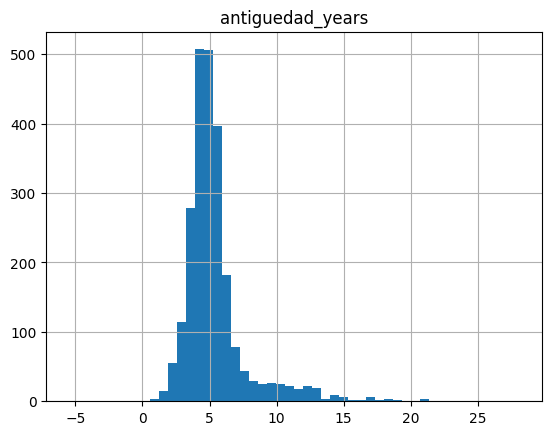

In [33]:
bmw4.hist("antiguedad_years",bins=50);

In [34]:
for indice, linea in bmw4.iterrows():
    modelo = linea['modelo']
    df_test = bmw4[(bmw4['modelo'] == modelo) & (bmw4['antiguedad_years'].notnull())]
    if not df_test.empty:
        antiguedad_years = df_test['antiguedad_years'].mean()
        bmw4.loc[indice, 'antiguedad_years'] = antiguedad_years

In [35]:
bmw4.isnull().sum()

modelo                     0
km                         0
potencia                   0
fecha_registro          2411
color                    442
tipo_coche                 0
volante_regulable          0
aire_acondicionado       483
camara_trasera             0
elevalunas_electrico       0
bluetooth                725
alerta_lim_velocidad     725
precio                     0
fecha_venta                0
antiguedad_days         2411
antiguedad_years          18
dtype: int64

In [36]:
def fill_na_with_mode_proportional(column):
    # Calcula la frecuencia de cada valor en la columna
    counts = column.value_counts(normalize=True)

    # Obtiene las opciones posibles
    posible_options = counts.keys().tolist()

    # Obtiene la proporcion de cada posible opcion
    proportions = counts.values.tolist()

    # Fillna con una serie con valores random que siguen la misma proporcion
    return column.fillna(pd.Series(np.random.choice(posible_options, len(column), p=proportions), index=column.index))

In [37]:
lista = []
for columna in bmw4.columns:
  if bmw4[columna].value_counts().count() <=2 and bmw4[columna].isnull().any():
    lista.append(columna)
    bmw4[columna] = fill_na_with_mode_proportional(bmw4[columna])
print(lista)



['aire_acondicionado', 'bluetooth', 'alerta_lim_velocidad']


In [38]:
def fill_na_with_mode_proportional(column):
    # Calcula la frecuencia de cada valor en la columna
    counts = column.value_counts(normalize=True)
    # Obtiene las opciones posibles
    posible_options = counts.keys().tolist()
    # Obtiene la proporcion de cada posible opcion
    proportions = counts.values.tolist()
    # Fillna con una serie con valores random que siguen la misma proporcion
    return column.fillna(pd.Series(np.random.choice(posible_options, len(column), p=proportions), index=column.index))
bmw4['color'] = fill_na_with_mode_proportional(bmw4['color'])

In [39]:
bmw4.isnull().sum()

modelo                     0
km                         0
potencia                   0
fecha_registro          2411
color                      0
tipo_coche                 0
volante_regulable          0
aire_acondicionado         0
camara_trasera             0
elevalunas_electrico       0
bluetooth                  0
alerta_lim_velocidad       0
precio                     0
fecha_venta                0
antiguedad_days         2411
antiguedad_years          18
dtype: int64

In [40]:
bmw4.dropna(subset='antiguedad_years',inplace=True)

In [41]:
bmw4.reset_index(drop=True, inplace=True)

In [42]:
bmw4.isnull().sum()

modelo                     0
km                         0
potencia                   0
fecha_registro          2393
color                      0
tipo_coche                 0
volante_regulable          0
aire_acondicionado         0
camara_trasera             0
elevalunas_electrico       0
bluetooth                  0
alerta_lim_velocidad       0
precio                     0
fecha_venta                0
antiguedad_days         2393
antiguedad_years           0
dtype: int64

In [43]:
del (bmw4["fecha_registro"])

In [44]:
del (bmw4["fecha_venta"])

In [45]:
del (bmw4["antiguedad_days"])

In [46]:
bmw4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804 entries, 0 to 4803
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   modelo                4804 non-null   object 
 1   km                    4804 non-null   float64
 2   potencia              4804 non-null   float64
 3   color                 4804 non-null   object 
 4   tipo_coche            4804 non-null   object 
 5   volante_regulable     4804 non-null   object 
 6   aire_acondicionado    4804 non-null   bool   
 7   camara_trasera        4804 non-null   object 
 8   elevalunas_electrico  4804 non-null   object 
 9   bluetooth             4804 non-null   bool   
 10  alerta_lim_velocidad  4804 non-null   bool   
 11  precio                4804 non-null   float64
 12  antiguedad_years      4804 non-null   float64
dtypes: bool(3), float64(4), object(6)
memory usage: 389.5+ KB


In [47]:
for columna in bmw4.columns:
    if bmw4[columna].nunique() == 2:
        bmw4[columna] = bmw4[columna].astype(bool)

In [48]:
bmw4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804 entries, 0 to 4803
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   modelo                4804 non-null   object 
 1   km                    4804 non-null   float64
 2   potencia              4804 non-null   float64
 3   color                 4804 non-null   object 
 4   tipo_coche            4804 non-null   object 
 5   volante_regulable     4804 non-null   bool   
 6   aire_acondicionado    4804 non-null   bool   
 7   camara_trasera        4804 non-null   bool   
 8   elevalunas_electrico  4804 non-null   bool   
 9   bluetooth             4804 non-null   bool   
 10  alerta_lim_velocidad  4804 non-null   bool   
 11  precio                4804 non-null   float64
 12  antiguedad_years      4804 non-null   float64
dtypes: bool(6), float64(4), object(3)
memory usage: 291.0+ KB


In [49]:
bmw5=bmw4.copy()

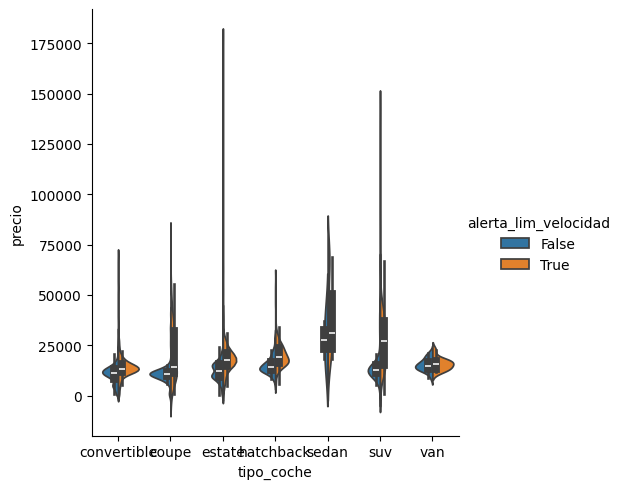

In [50]:
sns.catplot(data=bmw5,x="tipo_coche", y="precio", hue="alerta_lim_velocidad", kind= "violin", split=True);

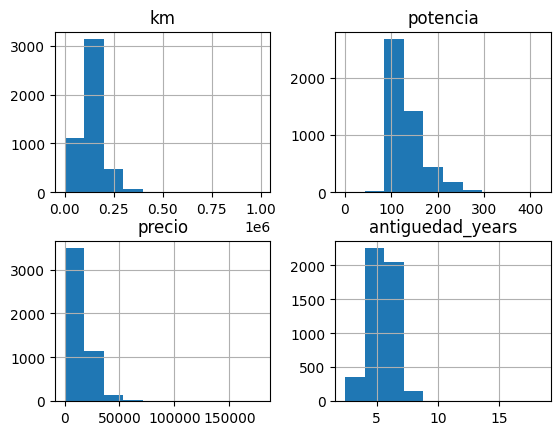

In [51]:
bmw5.hist();

## Análisis Univariable

In [52]:
bmw5['modelo'].value_counts(normalize=True)*100

modelo
320                  15.570358
520                  13.114072
318                  11.761032
X3                    9.096586
116                   7.452123
                       ...    
M135                  0.020816
220 Active Tourer     0.020816
635                   0.020816
ActiveHybrid 5        0.020816
214 Gran Tourer       0.020816
Name: proportion, Length: 64, dtype: float64

In [134]:
bmw5 = bmw5[bmw5['km'] > 0]

In [136]:
bmw5.describe()

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_years,...,modelo_serie_3,modelo_serie_4,modelo_serie_5,modelo_serie_6,modelo_serie_7,modelo_serie_A,modelo_serie_M,modelo_serie_X,modelo_serie_Z,modelo_serie_i
count,4.803000e+03,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,...,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000
mean,1.411923e+05,128.658755,0.549032,0.794295,0.200708,0.460129,0.242140,0.544660,15793.066833,5.490330,...,0.372684,0.020820,0.235478,0.005413,0.011035,0.000416,0.004580,0.220695,0.001249,0.001249
std,6.011100e+04,38.517449,0.497642,0.404258,0.400572,0.498460,0.428423,0.498053,9103.065504,0.909156,...,0.483569,0.142797,0.424341,0.073383,0.104476,0.020404,0.067531,0.414759,0.035326,0.035326
min,4.760000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,2.415525,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.032085e+05,100.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10850.000000,5.306122,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.411410e+05,120.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,14200.000000,5.594868,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.752730e+05,135.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,18600.000000,5.736910,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000376e+06,423.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,178500.000000,18.430137,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [137]:
for i in bmw5:
    print('\n', i, bmw5[i].value_counts(normalize=True)*100,'\n')


 km km
122543.0    0.041641
178558.0    0.041641
94829.0     0.041641
167205.0    0.041641
129317.0    0.041641
              ...   
141853.0    0.020820
124869.0    0.020820
266060.0    0.020820
232448.0    0.020820
195840.0    0.020820
Name: proportion, Length: 4746, dtype: float64 


 potencia potencia
135.0    18.217781
120.0    16.302311
85.0     13.075161
100.0    11.825942
105.0     9.327504
190.0     6.600042
140.0     3.456173
160.0     3.102228
110.0     2.935665
230.0     2.415157
155.0     2.061212
180.0     1.290860
225.0     0.999375
130.0     0.978555
150.0     0.853633
90.0      0.832813
280.0     0.666250
122.0     0.624610
173.0     0.520508
210.0     0.437227
137.0     0.395586
125.0     0.333125
170.0     0.249844
70.0      0.229024
75.0      0.187383
145.0     0.187383
235.0     0.145742
87.0      0.124922
142.0     0.124922
112.0     0.104102
220.0     0.104102
127.0     0.104102
317.0     0.083281
80.0      0.083281
119.0     0.083281
309.0     0.083281
95.0    

In [138]:
corr = bmw5.corr(numeric_only = True)

In [139]:
corr.style.background_gradient(cmap='coolwarm')

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_years,color_black,color_blue,color_brown,color_green,color_grey,color_orange,color_red,color_silver,color_white,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_suv,tipo_coche_van,modelo_serie_2,modelo_serie_3,modelo_serie_4,modelo_serie_5,modelo_serie_6,modelo_serie_7,modelo_serie_A,modelo_serie_M,modelo_serie_X,modelo_serie_Z,modelo_serie_i
km,1.000000,-0.042298,0.067461,0.013672,0.002061,0.046071,-0.025192,-0.030101,-0.409161,0.195933,0.033889,-0.011389,-0.026132,0.035786,0.025793,-0.030854,-0.027960,0.023694,-0.063355,-0.019795,0.059491,-0.047274,-0.019731,-0.113447,-0.089149,-0.120850,0.105705,-0.138542,0.167927,-0.024680,-0.000034,-0.023708,-0.021629,-0.117201,-0.021534,-0.037672
potencia,-0.042298,1.000000,0.326439,0.188371,0.313091,0.345463,0.190605,0.421912,0.645358,-0.018836,0.036055,-0.005160,-0.062087,-0.014762,-0.001481,0.011945,-0.005411,0.011134,0.003427,-0.098807,0.052303,-0.004402,0.183386,0.261552,-0.058682,-0.061018,-0.289767,0.055699,0.210303,0.192652,0.194374,0.017934,0.280892,0.244958,0.000466,-0.056927
volante_regulable,0.067461,0.326439,1.000000,0.286160,0.253577,0.278418,0.112792,0.200584,0.269553,0.027764,0.019418,0.009779,0.029934,0.014500,0.045764,0.008361,-0.028579,-0.013680,-0.103948,-0.080358,0.151845,0.012466,0.060059,0.079645,-0.044074,-0.065540,-0.203161,0.047172,0.270251,0.066863,0.091728,0.018498,0.042889,0.102938,0.032053,-0.003485
aire_acondicionado,0.013672,0.188371,0.286160,1.000000,0.128985,0.257957,0.097676,0.176992,0.223354,-0.022978,0.026872,-0.003430,0.039540,-0.027795,0.015659,0.003416,-0.042761,-0.027677,-0.052046,-0.018522,0.073774,0.046432,0.025917,-0.005896,-0.008975,-0.013420,-0.038124,0.016488,0.184100,0.030524,0.048825,0.010387,0.004009,-0.008636,-0.054914,0.017998
camara_trasera,0.002061,0.313091,0.253577,0.128985,1.000000,0.196531,0.125686,0.157561,0.255828,-0.004368,0.013658,-0.006014,-0.022174,0.011802,0.011890,-0.017722,-0.021484,0.004121,-0.002275,-0.039357,0.033416,0.058902,0.084972,0.119067,-0.015480,-0.017253,-0.152948,-0.000258,0.099235,0.097634,0.131180,-0.010228,0.019896,0.110615,-0.017722,-0.003006
elevalunas_electrico,0.046071,0.345463,0.278418,0.257957,0.196531,1.000000,0.213433,0.290487,0.267194,-0.018587,0.070619,-0.033903,-0.026679,-0.022440,-0.013060,0.014656,-0.022280,-0.028152,0.009958,-0.105359,0.128072,0.058262,0.027461,0.024045,-0.075608,-0.069338,-0.157784,0.111138,0.248688,0.057140,0.058435,0.001633,0.023986,0.031491,-0.020824,-0.032650
bluetooth,-0.025192,0.190605,0.112792,0.097676,0.125686,0.213433,1.000000,0.079600,0.175850,-0.037902,0.024450,0.003516,-0.041391,-0.002852,-0.035411,-0.006231,0.026796,-0.019992,0.052687,-0.022438,-0.002503,0.027364,-0.000626,-0.012807,-0.010446,-0.015662,-0.020537,0.091178,-0.009004,0.031161,-0.036445,0.036109,0.069624,0.009764,0.021289,0.007529
alerta_lim_velocidad,-0.030101,0.421912,0.200584,0.176992,0.157561,0.290487,0.079600,1.000000,0.380648,-0.004432,0.040706,-0.008985,-0.033529,-0.026027,-0.020698,-0.015008,-0.019488,-0.004611,0.023669,-0.088619,0.081078,0.056829,0.047918,0.112833,-0.033040,-0.030282,-0.163369,0.042557,0.207897,0.056060,0.080574,-0.001830,0.055832,0.129704,-0.038680,0.008665
precio,-0.409161,0.645358,0.269553,0.223354,0.255828,0.267194,0.175850,0.380648,1.000000,-0.209527,0.026056,-0.022950,-0.016253,-0.047197,-0.016447,0.011943,0.009519,-0.027686,0.051408,-0.030713,-0.000317,0.077754,0.153843,0.338711,-0.002806,0.011935,-0.308266,0.147514,0.058883,0.160416,0.153618,0.009546,0.161028,0.331768,-0.024452,0.020685
antiguedad_years,0.195933,-0.018836,0.027764,-0.022978,-0.004368,-0.018587,-0.037902,-0.004432,-0.209527,1.000000,0.009323,-0.013687,0.015931,0.063533,0.036100,0.008631,-0.032095,0.006116,-0.057842,-0.018944,0.129856,-0.301167,-0.146881,-0.079366,-0.238339,-0.286499,0.033689,-0.331205,0.157319,-0.070718,0.009011,-0.01

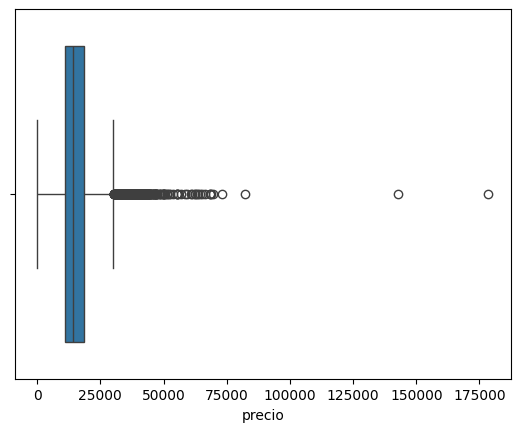

In [140]:
sns.boxplot(x=bmw5["precio"]);

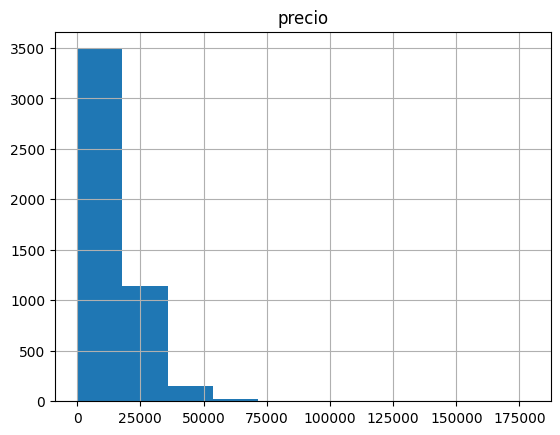

In [141]:
bmw5.hist("precio");

In [142]:
#bmw5["log_precio"]=np.log10(bmw5["precio"])

In [143]:
#bmw5.hist("log_precio", bins=50);

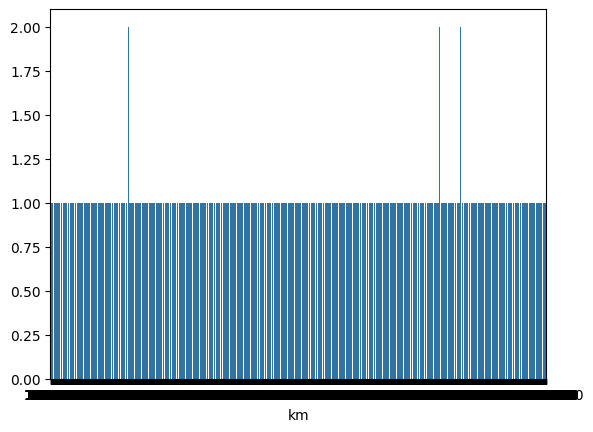

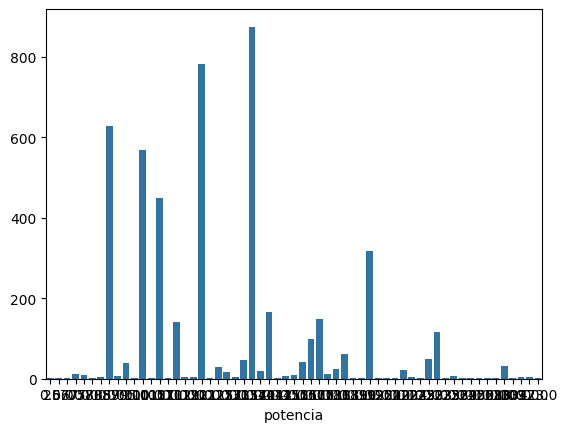

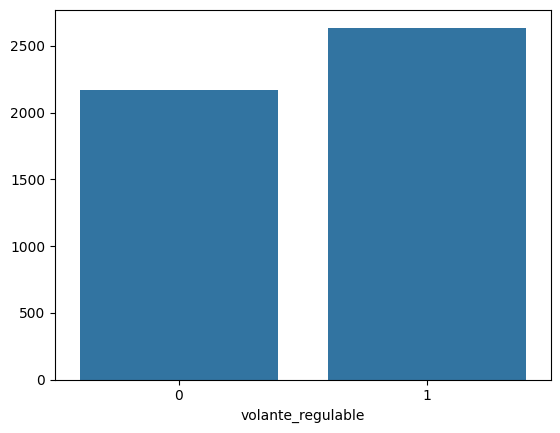

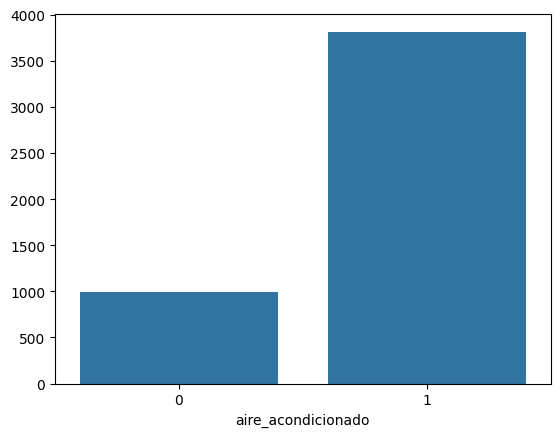

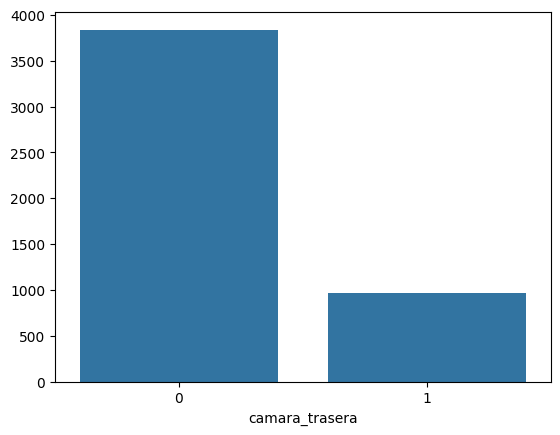

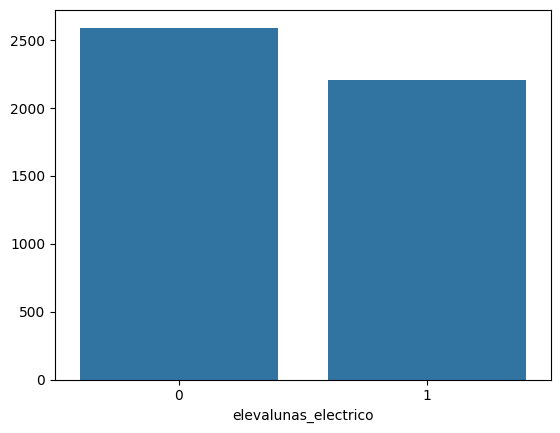

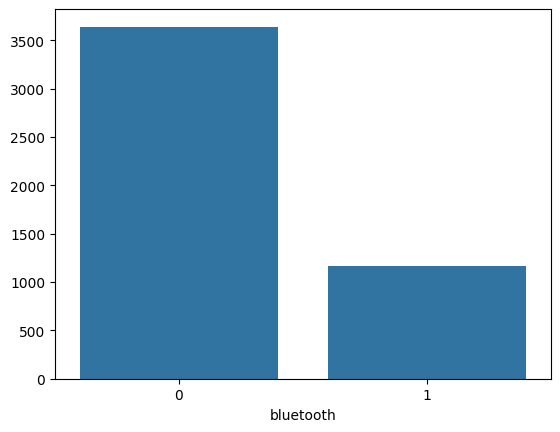

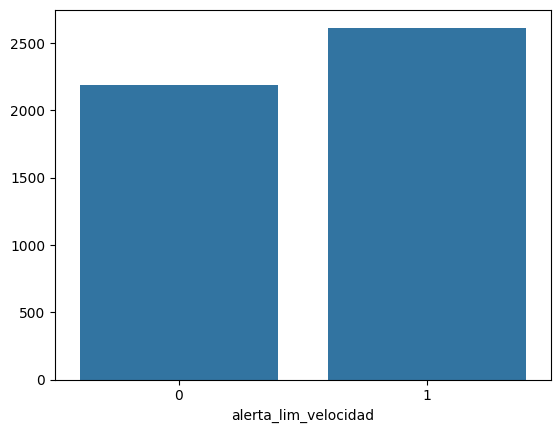

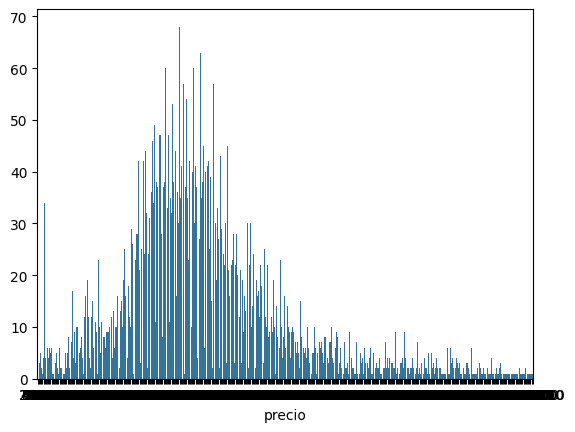

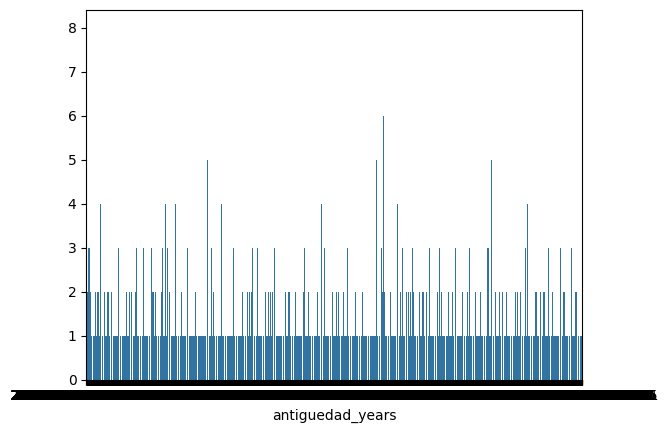

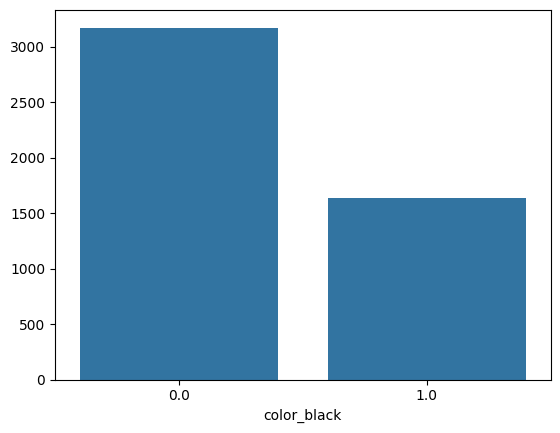

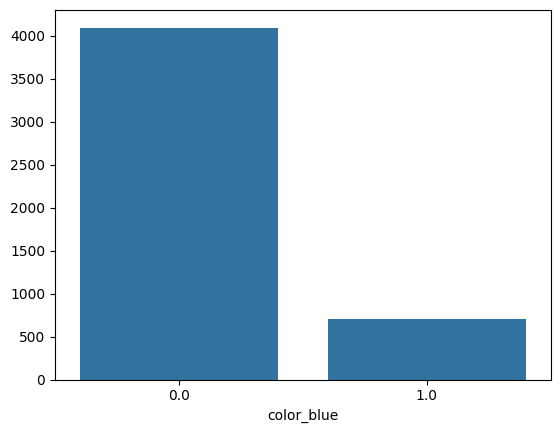

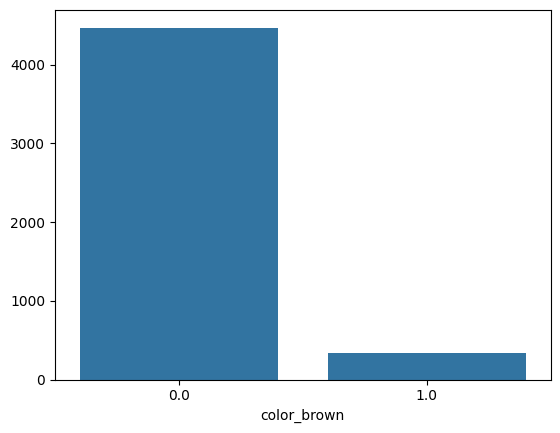

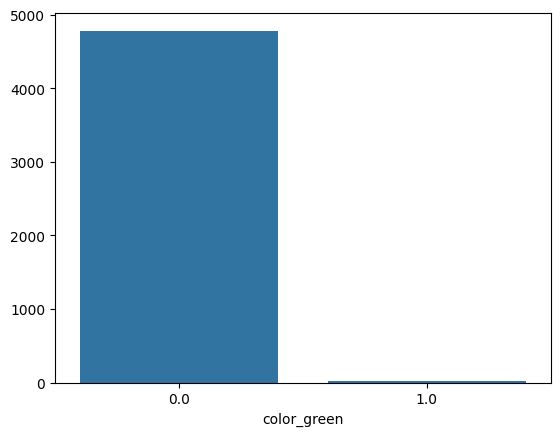

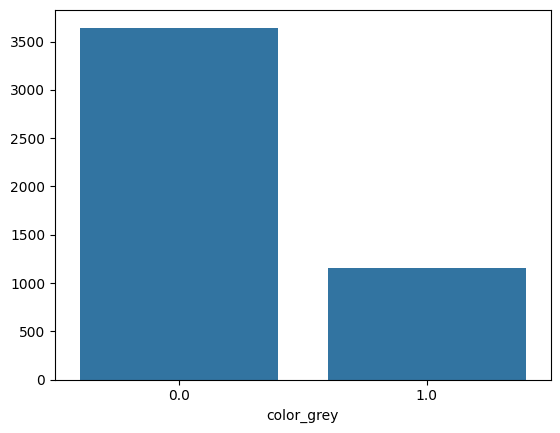

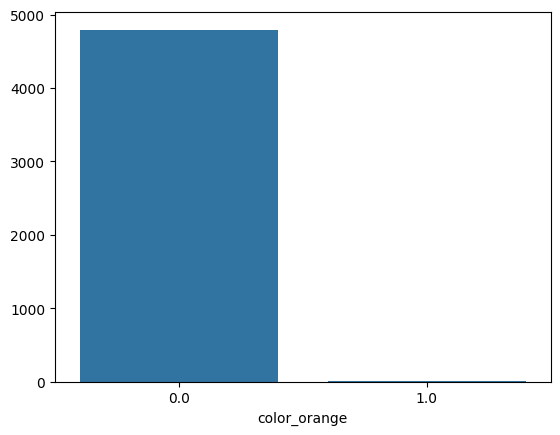

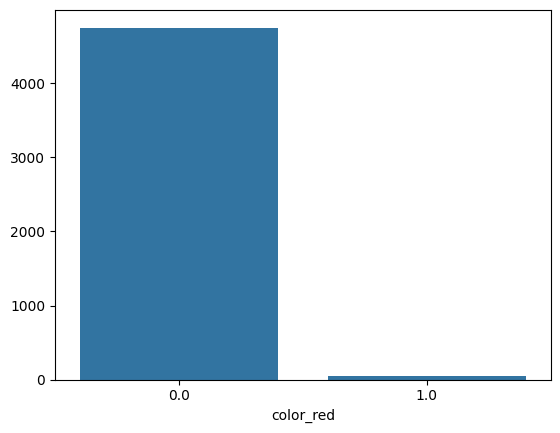

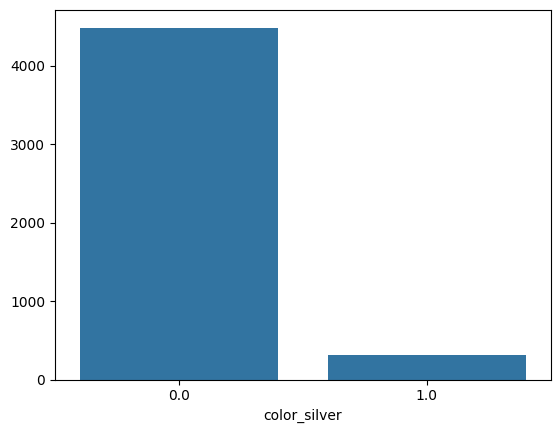

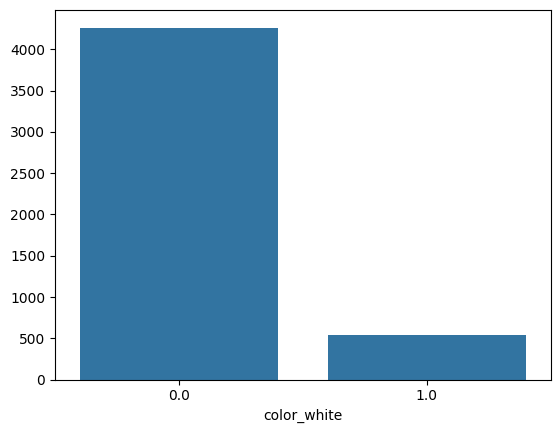

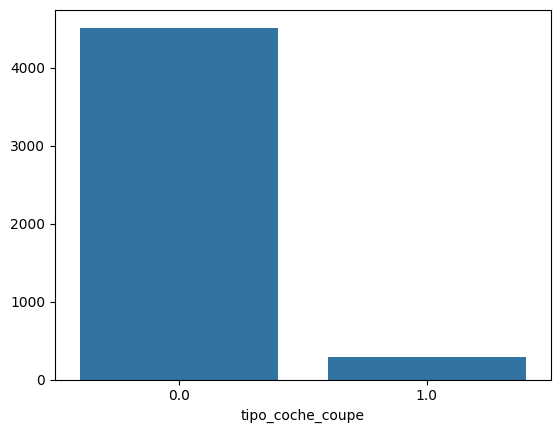

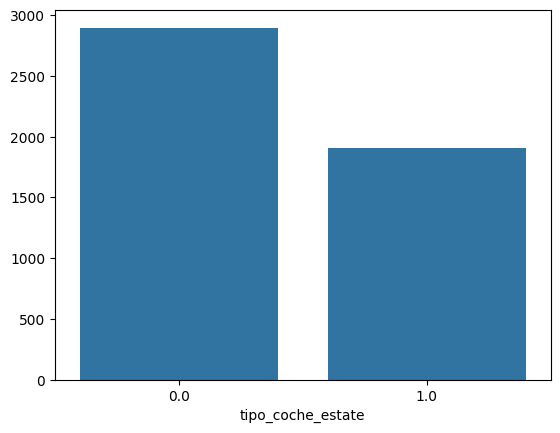

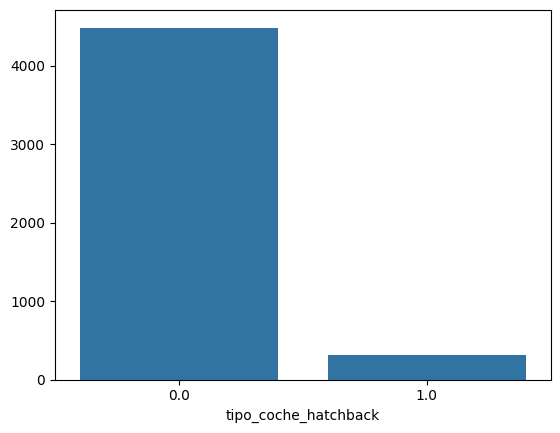

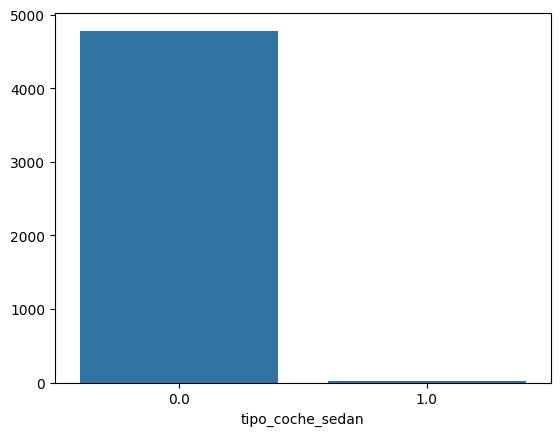

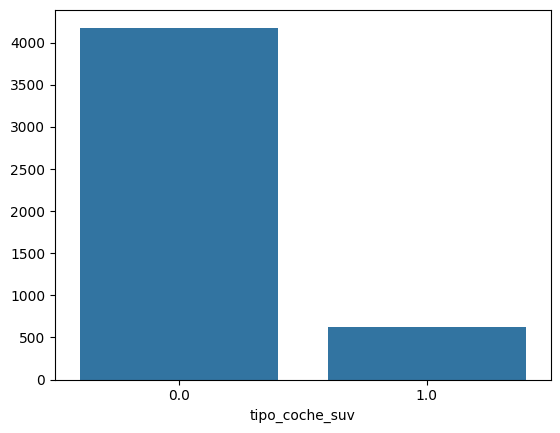

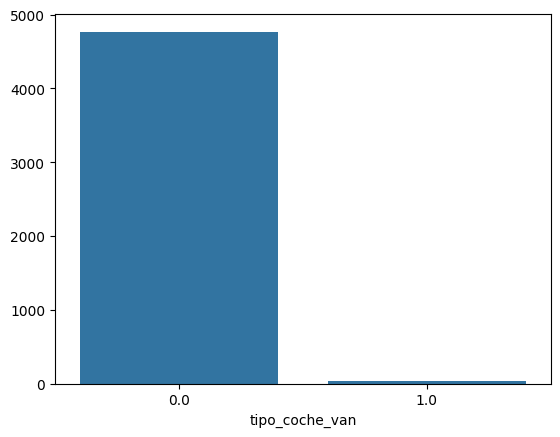

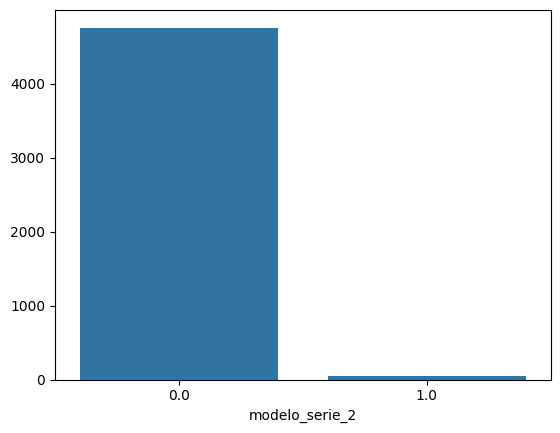

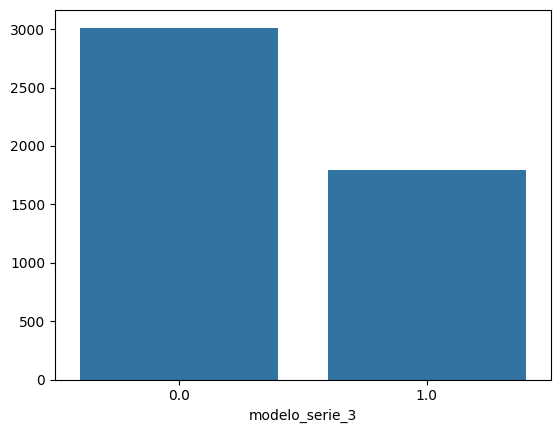

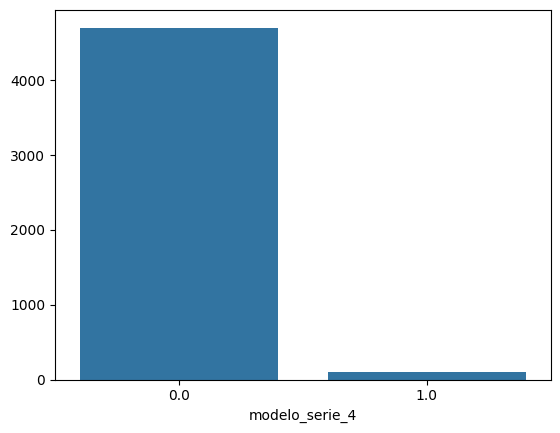

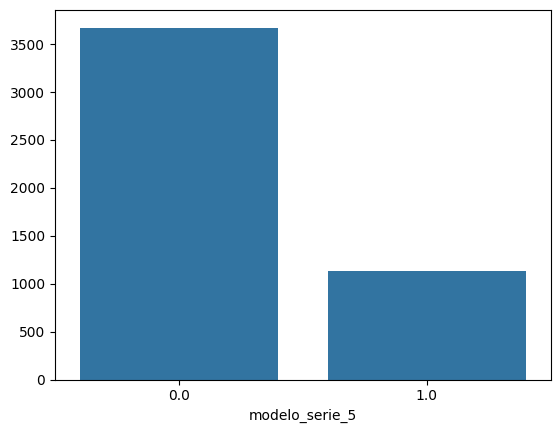

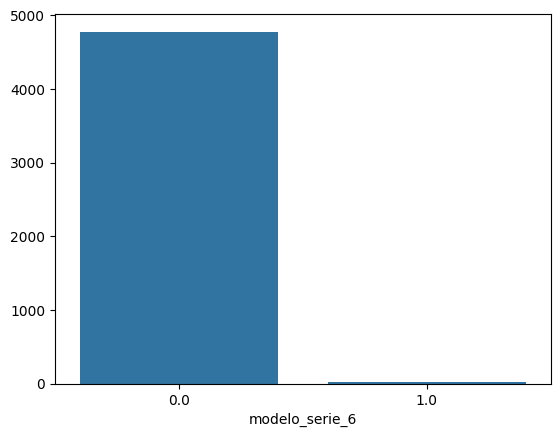

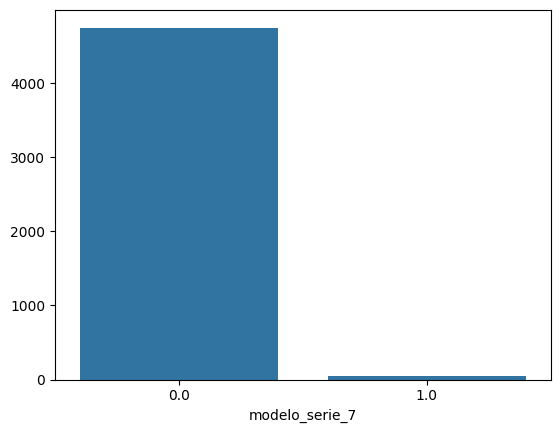

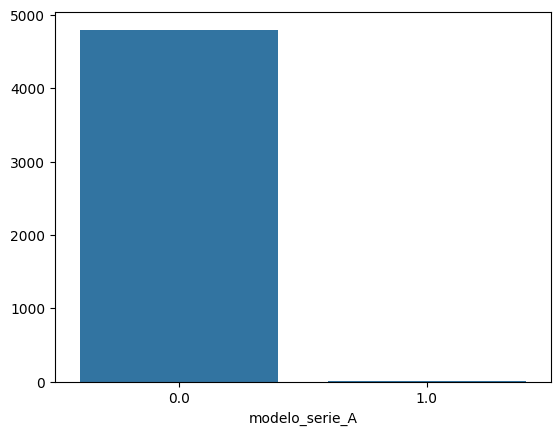

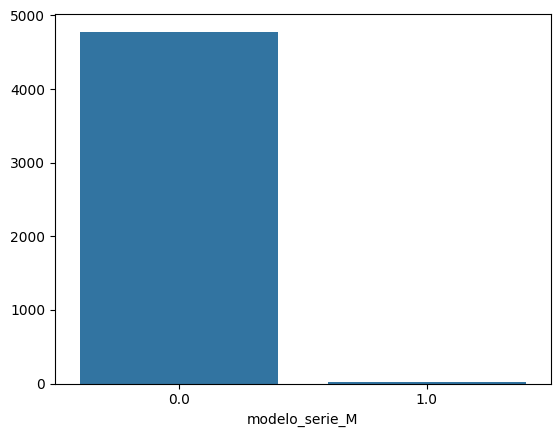

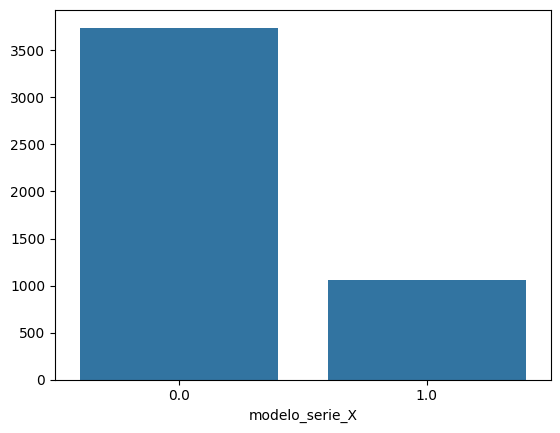

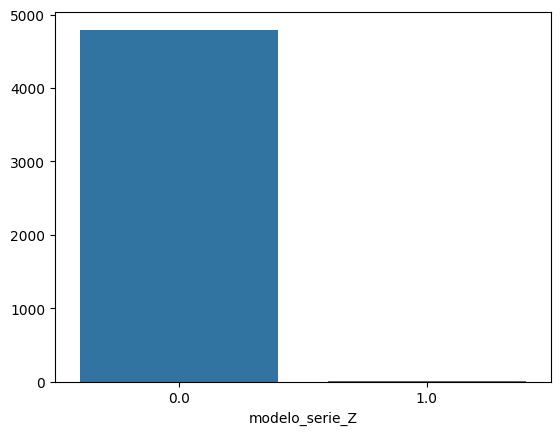

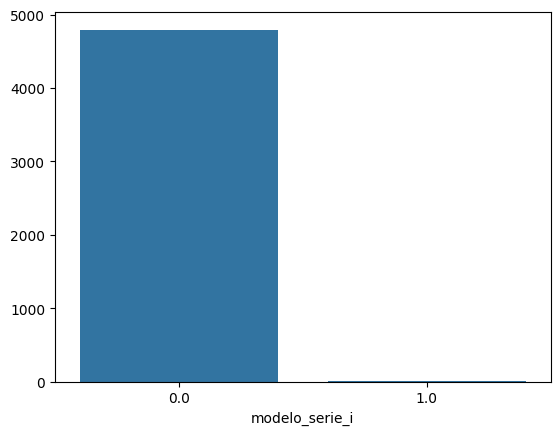

In [144]:
# any() - verifica cualquier de los elementos de la columna
# impresión de los gráficos

for columna in bmw5.columns:

  if bmw5[columna].astype(bool).any() == True or bmw5[columna].astype(object).any() == True:
    contaje = bmw5[columna].value_counts()
    sns.barplot(x = contaje.index, y=contaje.values)
    plt.show()

## Análisis Variable vs. Target

In [145]:
bmw5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4803 entries, 0 to 4803
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   km                    4803 non-null   float64
 1   potencia              4803 non-null   float64
 2   volante_regulable     4803 non-null   int64  
 3   aire_acondicionado    4803 non-null   int64  
 4   camara_trasera        4803 non-null   int64  
 5   elevalunas_electrico  4803 non-null   int64  
 6   bluetooth             4803 non-null   int64  
 7   alerta_lim_velocidad  4803 non-null   int64  
 8   precio                4803 non-null   float64
 9   antiguedad_years      4803 non-null   float64
 10  color_black           4803 non-null   float64
 11  color_blue            4803 non-null   float64
 12  color_brown           4803 non-null   float64
 13  color_green           4803 non-null   float64
 14  color_grey            4803 non-null   float64
 15  color_orange          4803

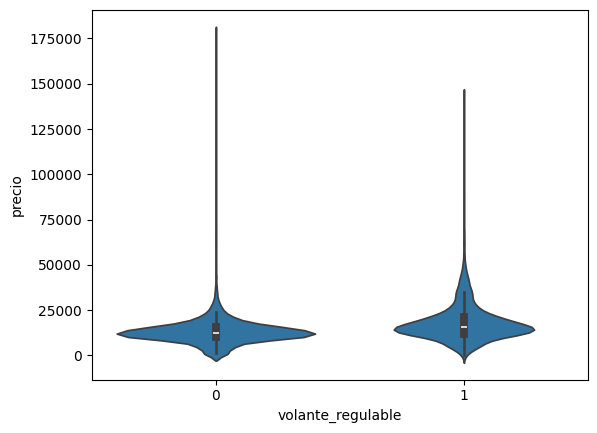

In [146]:
sns.violinplot(x="volante_regulable",y="precio",data=bmw5);

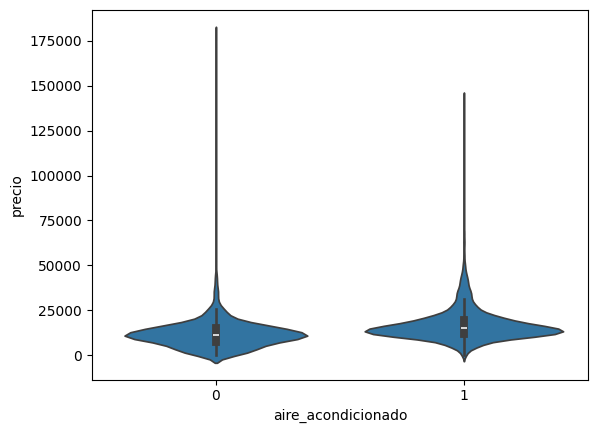

In [147]:
sns.violinplot(x="aire_acondicionado",y="precio",data=bmw5);

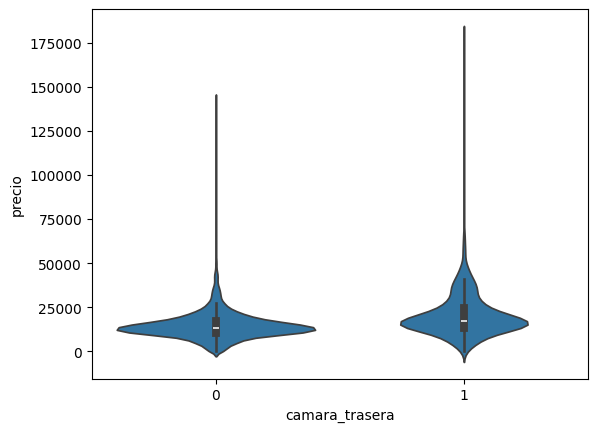

In [148]:
sns.violinplot(x="camara_trasera",y="precio",data=bmw5);

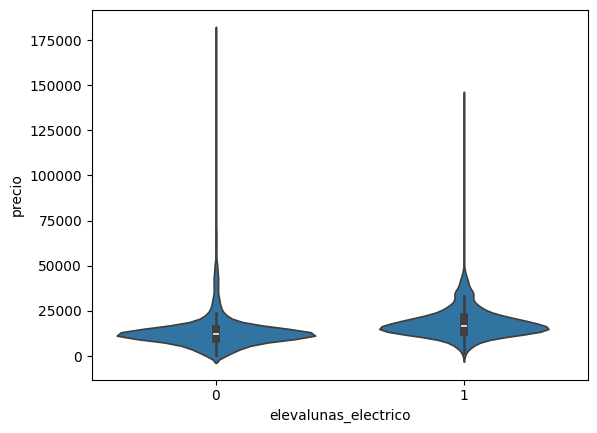

In [149]:
sns.violinplot(x="elevalunas_electrico",y="precio",data=bmw5);

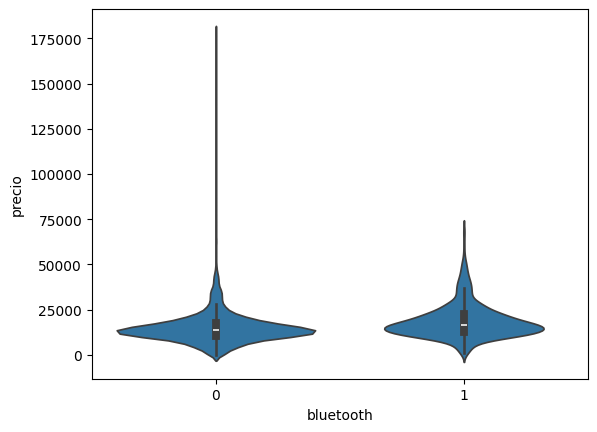

In [150]:
sns.violinplot(x="bluetooth",y="precio",data=bmw5);

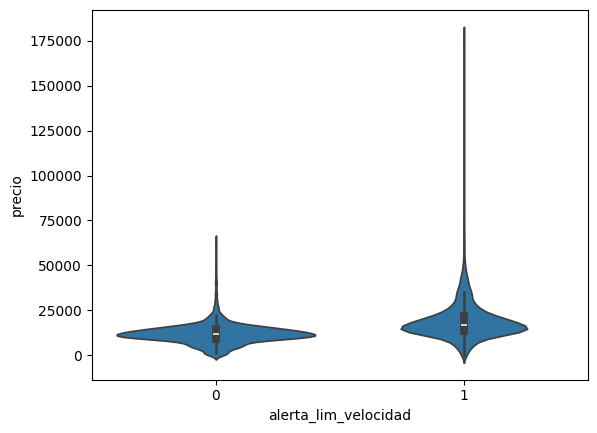

In [151]:
sns.violinplot(x="alerta_lim_velocidad",y="precio",data=bmw5);

In [152]:
#sns.catplot(data=bmw5,x="precio",y="antiguedad_years", kind="swarm", hue="tipo_coche");

In [153]:
bmw4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804 entries, 0 to 4803
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   modelo                4804 non-null   object 
 1   km                    4804 non-null   float64
 2   potencia              4804 non-null   float64
 3   color                 4804 non-null   object 
 4   tipo_coche            4804 non-null   object 
 5   volante_regulable     4804 non-null   bool   
 6   aire_acondicionado    4804 non-null   bool   
 7   camara_trasera        4804 non-null   bool   
 8   elevalunas_electrico  4804 non-null   bool   
 9   bluetooth             4804 non-null   bool   
 10  alerta_lim_velocidad  4804 non-null   bool   
 11  precio                4804 non-null   float64
 12  antiguedad_years      4804 non-null   float64
dtypes: bool(6), float64(4), object(3)
memory usage: 291.0+ KB


In [154]:
bmw4.head(15)

,modelo,km,potencia,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_years
0,118,140411.0,100.0,black,convertible,True,True,False,True,False,True,11300.0,6.248093
1,M4,13929.0,317.0,grey,convertible,True,True,False,False,True,True,69700.0,3.079452
2,320,183297.0,120.0,white,convertible,False,False,False,True,False,False,10200.0,5.620605
3,420,128035.0,135.0,red,convertible,True,True,False,True,True,True,25100.0,3.748402
4,335,152352.0,225.0,black,coupe,True,True,False,True,True,True,17100.0,6.017352
5,325,205219.0,145.0,grey,convertible,True,True,False,True,True,True,12400.0,6.372798
6,118,115560.0,105.0,white,convertible,True,True,False,False,True,False,6100.0,6.253132
7,Z4,123886.0,125.0,black,convertible,True,False,False,False,False,False,6200.0,13.008219
8,320,139541.0,135.0,white,convertible,False,False,False,True,False,False,17300.0,5.619994
9,320,77115.0,135.0,blue,convertible,True,True,False,True,False,True,19300.0,5.619994


In [155]:
bmw5 = bmw4.copy()

In [156]:
for i in bmw5.select_dtypes(include=['bool']).columns:
    label_encoder = LabelEncoder()
    bmw5[i] = label_encoder.fit_transform(bmw5[i])

In [157]:
bmw5.head(15)

,modelo,km,potencia,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_years
0,118,140411.0,100.0,black,convertible,1,1,0,1,0,1,11300.0,6.248093
1,M4,13929.0,317.0,grey,convertible,1,1,0,0,1,1,69700.0,3.079452
2,320,183297.0,120.0,white,convertible,0,0,0,1,0,0,10200.0,5.620605
3,420,128035.0,135.0,red,convertible,1,1,0,1,1,1,25100.0,3.748402
4,335,152352.0,225.0,black,coupe,1,1,0,1,1,1,17100.0,6.017352
5,325,205219.0,145.0,grey,convertible,1,1,0,1,1,1,12400.0,6.372798
6,118,115560.0,105.0,white,convertible,1,1,0,0,1,0,6100.0,6.253132
7,Z4,123886.0,125.0,black,convertible,1,0,0,0,0,0,6200.0,13.008219
8,320,139541.0,135.0,white,convertible,0,0,0,1,0,0,17300.0,5.619994
9,320,77115.0,135.0,blue,convertible,1,1,0,1,0,1,19300.0,5.619994


In [158]:
bmw5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804 entries, 0 to 4803
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   modelo                4804 non-null   object 
 1   km                    4804 non-null   float64
 2   potencia              4804 non-null   float64
 3   color                 4804 non-null   object 
 4   tipo_coche            4804 non-null   object 
 5   volante_regulable     4804 non-null   int64  
 6   aire_acondicionado    4804 non-null   int64  
 7   camara_trasera        4804 non-null   int64  
 8   elevalunas_electrico  4804 non-null   int64  
 9   bluetooth             4804 non-null   int64  
 10  alerta_lim_velocidad  4804 non-null   int64  
 11  precio                4804 non-null   float64
 12  antiguedad_years      4804 non-null   float64
dtypes: float64(4), int64(6), object(3)
memory usage: 488.0+ KB


In [159]:
bmw5.head(5)

,modelo,km,potencia,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_years
0,118,140411.0,100.0,black,convertible,1,1,0,1,0,1,11300.0,6.248093
1,M4,13929.0,317.0,grey,convertible,1,1,0,0,1,1,69700.0,3.079452
2,320,183297.0,120.0,white,convertible,0,0,0,1,0,0,10200.0,5.620605
3,420,128035.0,135.0,red,convertible,1,1,0,1,1,1,25100.0,3.748402
4,335,152352.0,225.0,black,coupe,1,1,0,1,1,1,17100.0,6.017352


In [160]:
#Agrupar columna model por el primer caracter para crear una nueva columna modelo_serie

In [161]:
bmw5['modelo_serie'] = bmw5['modelo'].str.extract(r'([A-Za-z0-9])')[0]

In [162]:
bmw5.head(5)

,modelo,km,potencia,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_years,modelo_serie
0,118,140411.0,100.0,black,convertible,1,1,0,1,0,1,11300.0,6.248093,1
1,M4,13929.0,317.0,grey,convertible,1,1,0,0,1,1,69700.0,3.079452,M
2,320,183297.0,120.0,white,convertible,0,0,0,1,0,0,10200.0,5.620605,3
3,420,128035.0,135.0,red,convertible,1,1,0,1,1,1,25100.0,3.748402,4
4,335,152352.0,225.0,black,coupe,1,1,0,1,1,1,17100.0,6.017352,3


In [163]:
# drop column modelo
bmw5 = bmw5.drop('modelo', axis=1)

In [164]:
bmw5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804 entries, 0 to 4803
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   km                    4804 non-null   float64
 1   potencia              4804 non-null   float64
 2   color                 4804 non-null   object 
 3   tipo_coche            4804 non-null   object 
 4   volante_regulable     4804 non-null   int64  
 5   aire_acondicionado    4804 non-null   int64  
 6   camara_trasera        4804 non-null   int64  
 7   elevalunas_electrico  4804 non-null   int64  
 8   bluetooth             4804 non-null   int64  
 9   alerta_lim_velocidad  4804 non-null   int64  
 10  precio                4804 non-null   float64
 11  antiguedad_years      4804 non-null   float64
 12  modelo_serie          4804 non-null   object 
dtypes: float64(4), int64(6), object(3)
memory usage: 488.0+ KB


In [165]:
from sklearn.preprocessing import  OneHotEncoder, LabelEncoder



# Aplicando OneHotEncoder para colunas categóricas
ohe = OneHotEncoder(sparse=False, drop='first')
categorical_columns = []

for columna in bmw5.select_dtypes(include=['object']).columns:

    categorical_columns.append(columna)

# Transformar as colunas categóricas em representações one-hot e adicionar ao DataFrame original
one_hot_encoded_array = ohe.fit_transform(bmw5[categorical_columns])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_array, columns=ohe.get_feature_names_out(categorical_columns))
bmw5 = pd.concat([bmw5.drop(columns=categorical_columns), one_hot_encoded_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [166]:
bmw5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804 entries, 0 to 4803
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   km                    4804 non-null   float64
 1   potencia              4804 non-null   float64
 2   volante_regulable     4804 non-null   int64  
 3   aire_acondicionado    4804 non-null   int64  
 4   camara_trasera        4804 non-null   int64  
 5   elevalunas_electrico  4804 non-null   int64  
 6   bluetooth             4804 non-null   int64  
 7   alerta_lim_velocidad  4804 non-null   int64  
 8   precio                4804 non-null   float64
 9   antiguedad_years      4804 non-null   float64
 10  color_black           4804 non-null   float64
 11  color_blue            4804 non-null   float64
 12  color_brown           4804 non-null   float64
 13  color_green           4804 non-null   float64
 14  color_grey            4804 non-null   float64
 15  color_orange         

In [167]:
bmw5.describe()

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_years,...,modelo_serie_3,modelo_serie_4,modelo_serie_5,modelo_serie_6,modelo_serie_7,modelo_serie_A,modelo_serie_M,modelo_serie_X,modelo_serie_Z,modelo_serie_i
count,4.804000e+03,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,...,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000
mean,1.411629e+05,128.679850,0.549126,0.794338,0.200666,0.460033,0.242090,0.544754,15805.391341,5.490015,...,0.372606,0.020816,0.235429,0.005620,0.011032,0.000416,0.004580,0.220649,0.001249,0.001249
std,6.013929e+04,38.541183,0.497633,0.404227,0.400540,0.498452,0.428393,0.498045,9142.113810,0.909322,...,0.483549,0.142783,0.424311,0.074766,0.104465,0.020402,0.067524,0.414728,0.035322,0.035322
min,-6.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,2.415525,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.031700e+05,100.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10875.000000,5.306082,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.411305e+05,120.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,14200.000000,5.594798,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.752695e+05,135.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,18600.000000,5.736897,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000376e+06,423.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,178500.000000,18.430137,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [168]:
#minMaxResultado=MinMaxScaler()

from sklearn.preprocessing import  MinMaxScaler

scaler = MinMaxScaler()


bmw_minmax= pd.DataFrame(scaler.fit_transform(bmw5), columns=bmw5.columns)


In [169]:
df_bmw50 = bmw_minmax.head(50)

In [170]:
bmw_minmax.describe()

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_years,...,modelo_serie_3,modelo_serie_4,modelo_serie_5,modelo_serie_6,modelo_serie_7,modelo_serie_A,modelo_serie_M,modelo_serie_X,modelo_serie_Z,modelo_serie_i
count,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,...,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000,4804.000000
mean,0.141165,0.304208,0.549126,0.794338,0.200666,0.460033,0.242090,0.544754,0.088035,0.191980,...,0.372606,0.020816,0.235429,0.005620,0.011032,0.000416,0.004580,0.220649,0.001249,0.001249
std,0.060113,0.091114,0.497633,0.404227,0.400540,0.498452,0.428393,0.498045,0.051245,0.056781,...,0.483549,0.142783,0.424311,0.074766,0.104465,0.020402,0.067524,0.414728,0.035322,0.035322
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.103189,0.236407,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.060398,0.180495,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.141132,0.283688,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.079036,0.198523,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.175256,0.319149,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.103700,0.207396,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [171]:
df_bmw50.to_excel('bmw50.xlsx')

In [172]:
#bmw6=minMaxResultado.fit_transform(bmw6)

corr =bmw_minmax.corr()

corr.style.background_gradient(cmap='coolwarm')

,km,potencia,volante_regulable,aire_acondicionado,camara_trasera,elevalunas_electrico,bluetooth,alerta_lim_velocidad,precio,antiguedad_years,color_black,color_blue,color_brown,color_green,color_grey,color_orange,color_red,color_silver,color_white,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_suv,tipo_coche_van,modelo_serie_2,modelo_serie_3,modelo_serie_4,modelo_serie_5,modelo_serie_6,modelo_serie_7,modelo_serie_A,modelo_serie_M,modelo_serie_X,modelo_serie_Z,modelo_serie_i
km,1.000000,-0.043528,0.066973,0.013415,0.002304,0.046492,-0.024900,-0.030528,-0.410303,0.196577,0.033182,-0.011179,-0.025984,0.035795,0.026053,-0.030819,-0.027893,0.023811,-0.063144,-0.021681,0.059849,-0.047116,-0.019687,-0.113192,-0.089058,-0.120732,0.106015,-0.138391,0.168096,-0.030711,0.000018,-0.023684,-0.021584,-0.116870,-0.021504,-0.037633
potencia,-0.043528,1.000000,0.326673,0.188509,0.312584,0.344679,0.190153,0.422072,0.645617,-0.019727,0.036785,-0.005384,-0.062191,-0.014785,-0.001789,0.011917,-0.005464,0.010980,0.003230,-0.096416,0.051818,-0.004545,0.183217,0.261149,-0.058685,-0.061028,-0.289963,0.055579,0.209841,0.196216,0.194176,0.017910,0.280653,0.244483,0.000447,-0.056905
volante_regulable,0.066973,0.326673,1.000000,0.286224,0.253454,0.278195,0.112672,0.200722,0.269572,0.027441,0.019675,0.009700,0.029880,0.014487,0.045652,0.008354,-0.028596,-0.013729,-0.104005,-0.079477,0.151669,0.012415,0.060041,0.079564,-0.044085,-0.065553,-0.203276,0.047140,0.270115,0.068123,0.091701,0.018493,0.042872,0.102826,0.032043,-0.003491
aire_acondicionado,0.013415,0.188509,0.286224,1.000000,0.128925,0.257829,0.097610,0.177069,0.223057,-0.023147,0.027014,-0.003474,0.039510,-0.027801,0.015599,0.003412,-0.042770,-0.027704,-0.052082,-0.018074,0.073681,0.046402,0.025909,-0.005937,-0.008983,-0.013430,-0.038203,0.016472,0.184030,0.031365,0.048812,0.010384,0.004001,-0.008691,-0.054916,0.017994
camara_trasera,0.002304,0.312584,0.253454,0.128925,1.000000,0.196604,0.125737,0.157448,0.254026,-0.004193,0.013510,-0.005970,-0.022145,0.011808,0.011948,-0.017718,-0.021472,0.004149,-0.002237,-0.039703,0.033498,0.058928,0.084977,0.119103,-0.015471,-0.017242,-0.152854,-0.000243,0.099287,0.094429,0.131187,-0.010225,0.019902,0.110665,-0.017718,-0.003002
elevalunas_electrico,0.046492,0.344679,0.278195,0.257829,0.196604,1.000000,0.213515,0.290261,0.264757,-0.018261,0.070331,-0.033819,-0.026624,-0.022426,-0.012950,0.014661,-0.022258,-0.028098,0.010025,-0.105937,0.128207,0.058308,0.027471,0.024117,-0.075585,-0.069313,-0.157612,0.111156,0.248765,0.053516,0.058450,0.001637,0.023997,0.031589,-0.020815,-0.032640
bluetooth,-0.024900,0.190153,0.112672,0.097610,0.125737,0.213515,1.000000,0.079482,0.174313,-0.037694,0.024280,0.003565,-0.041357,-0.002844,-0.035343,-0.006227,0.026807,-0.019960,0.052727,-0.022865,-0.002407,0.027395,-0.000618,-0.012761,-0.010436,-0.015650,-0.020444,0.091192,-0.008938,0.029015,-0.036431,0.036110,0.069630,0.009826,0.021292,0.007533
alerta_lim_velocidad,-0.030528,0.422072,0.200722,0.177069,0.157448,0.290261,0.079482,1.000000,0.380183,-0.004747,0.040959,-0.009063,-0.033578,-0.026036,-0.020803,-0.015013,-0.019506,-0.004661,0.023599,-0.087717,0.080911,0.056773,0.047901,0.112748,-0.033053,-0.030298,-0.163491,0.042525,0.207767,0.057544,0.080547,-0.001834,0.055814,0.129587,-0.038683,0.008657
precio,-0.410303,0.645617,0.269572,0.223057,0.254026,0.264757,0.174313,0.380183,1.000000,-0.210790,0.027815,-0.023410,-0.016550,-0.047073,-0.017134,0.011843,0.009338,-0.027924,0.050702,-0.025210,-0.001409,0.077055,0.153080,0.336703,-0.002904,0.011751,-0.307937,0.146671,0.057876,0.174678,0.152803,0.009476,0.160232,0.329589,-0.024392,0.020547
antiguedad_years,0.196577,-0.019727,0.027441,-0.023147,-0.004193,-0.018261,-0.037694,-0.004747,-0.210790,1.000000,0.008836,-0.013539,0.016020,0.063536,0.036284,0.008641,-0.032049,0.006206,-0.057702,-0.020273,0.130091,-0.300986,-0.146816,-0.079208,-0.238242,-0.286383,0.033944,-0.331058,0.157460,-0.073985,0.009045,-0.016

In [173]:
#bmw6.head(10)

In [174]:
#corr_f = bmw6.corr()

In [175]:
#corr_f.style.background_gradient(cmap='coolwarm')